In [9]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Amazon_mobile_clean.csv')
df_clean.head()

,review_body,star_rating,vine,verified_purchase,subjectivity,polarity,s_subjectivity,s_polarity,sentiment,s_sentiment,character_count,word_count,s_word_count,unique_word_count,syllable_count,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index,coleman_liau_index,linsear_write_formula,dale_chall_readability_score,noun_count,verb_count,adv_count,adj_count,helpfulness
0,advertised everything works perfectly im happy...,5.0,0,1,1.000000,0.800000,1.00,0.8,2,2,94,15,1,14,27,39.33,11.5,11.2,13.04,11.5,9.64,6,4,1,1,0
1,great,5.0,0,1,0.750000,0.800000,0.00,0.0,2,1,5,1,2,1,1,121.22,-3.5,2.6,-16.41,-0.5,0.05,0,0,0,1,0
2,work great fit life proof case iphone,5.0,0,1,0.575000,0.600000,0.75,0.8,2,2,37,7,2,7,7,115.13,-1.2,2.9,5.75,2.5,8.50,5,0,0,2,0
3,work well couldnt get used hearing anything ea...,4.0,0,1,0.000000,0.000000,0.00,0.0,1,1,55,9,6,9,12,87.72,3.3,7.7,11.22,3.5,7.59,3,3,1,2,0
4,careful products bought several cameras image ...,2.0,0,1,0.666667,0.079167,0.00,0.0,2,1,86,12,3,12,22,42.38,10.3,14.0,18.08,6.0,12.13,6,2,1,3,0


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(2,2))
# TF-IDF feature matrix
tfidf_idf = tfidf_vectorizer.fit_transform(df_clean['review_body'].values.astype('str'))

In [15]:
tfidf_idf

<104847x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 717445 stored elements in Compressed Sparse Row format>

In [16]:
# Here we are using all the features except the helpfulness ratio which is the target column for our model

from scipy.sparse import hstack, csr_matrix

meta_features = [
'star_rating',
'vine',
'verified_purchase',
'subjectivity',
'polarity',
's_subjectivity',
's_polarity',
'sentiment',
's_sentiment',
'character_count',
'word_count',
's_word_count',
'unique_word_count',
'syllable_count',
'flesch_reading_ease',
'flesch_kincaid_grade',
'automated_readability_index',
'coleman_liau_index',
'linsear_write_formula',
'dale_chall_readability_score',
'noun_count',
'verb_count',
'adv_count',
'adj_count']

feature_set1 = df_clean[meta_features]

train = hstack([tfidf_idf, csr_matrix(feature_set1)], "csr")
train

<104847x10024 sparse matrix of type '<class 'numpy.float64'>'
	with 2940202 stored elements in Compressed Sparse Row format>

In [17]:
target = df_clean['helpfulness'].values

In [18]:
# Defining the X
X = train
## defining the target columns
y = target

In [19]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=130)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({0: 78054, 1: 26793})
Resampled dataset shape Counter({0: 78054, 1: 78054})


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state=0)

In [21]:
# Define a function to plot the ROC/AUC
def evbiclas(model,cr=0):
  preds = model.predict(X_test)
  print('\n'+'\033[1m'+type(model).__name__+'\033[0;0m')    
  print("----------------------------------")
  print("\nTrain Accuracy:","{:.2f}".format(model.score(X_train, y_train)*100))

  print("\nTest Accuracy:", "{:.2f}".format(model.score(X_test, y_test)*100))

  print("\nClassification report:")
  print(classification_report(preds, y_test))

  print("\nConfusion matrix:")
  # Creating the confusion matrix
  cm = confusion_matrix(preds, y_test)
  # Assigning columns names
  cm_df = pd.DataFrame(cm, 
              columns = ['Predicted Positive','Predicted Negative'],
              index = [ 'Actual Positive','Actual Negative'])
  print(cm_df)
  print("----------------------------------")
  sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
  print('\nSensitivity : ',"{:.2f}".format(sensitivity1*100))

  specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
  print('Specificity : ', "{:.2f}".format(specificity1*100))
  print("\nROC / AUC:")


  probabilities = model.predict_proba(X_test)
  probabilities = probabilities[:, 1]  # keep probabilities for first class only
        
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, probabilities)    
  plt.figure(figsize = (10,7))
  plt.title(f"ROC Curve with AUC = {str(round(roc_auc_score(y_test, probabilities),3))}", fontsize=22)
  # Plot the "dumb model" line
  plt.plot([0, 1], [0, 1], linestyle='--',label='baseline')
    
  # Plot the model line
  plt.plot(fpr, tpr, marker='.',label='ROC Curve')
  plt.text(0.75, 0.25, "AUC: " + str(round(roc_auc_score(y_test, probabilities),3)),fontsize=18)
    
  plt.ylabel('Sensitivity', fontsize=18)
  plt.xlabel('1 - Specificity', fontsize=18)

  plt.legend(fontsize=16)
    
  # show the plot
  plt.show();




  print("\n----------------------------------")
  print("\nCross Validation 10K fold Result")
  print('\n')
  if type(cr)==int:
    print('\033[1m*Cross validation Result Not avaible*\033[0;0m')
  else:
    ud=1
    for i in cr:
      print('K',ud,':',"{:.2f}".format(i*100))
      ud=ud+1
  print("\n----------------------------------")
  print('The Model Parameters:','\n',model.get_params())

##### LGBM Classifier
##### Accuracy 82.8%


LGBMClassifier
----------------------------------

Train Accuracy: 84.32

Test Accuracy: 83.36

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85     23611
           1       0.73      0.93      0.81     15416

    accuracy                           0.83     39027
   macro avg       0.83      0.85      0.83     39027
weighted avg       0.86      0.83      0.84     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               18226                5385
Actual Negative                1110               14306
----------------------------------

Sensitivity :  77.19
Specificity :  92.80

ROC / AUC:


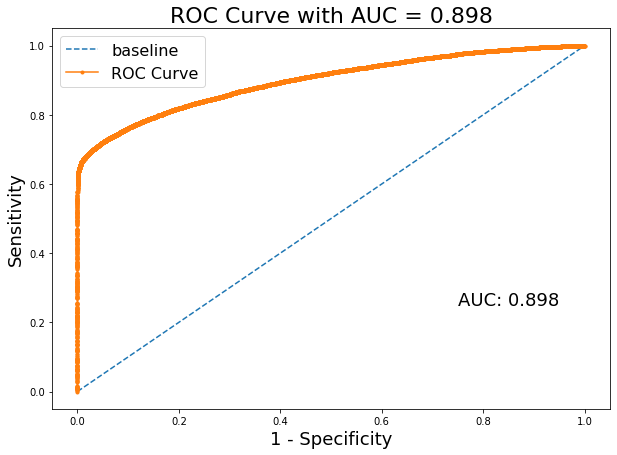


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [22]:

import lightgbm as lgb
import matplotlib.pyplot as plt
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)


## LGBM Classifier is one of our best performance with above 80percent accuracy.